In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as T
from PIL import Image
import time

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Codificador
        self.encoder1 = self._block(in_channels, 32)
        self.encoder2 = self._block(32, 64)
        self.encoder3 = self._block(64, 128)
        self.encoder4 = self._block(128, 256)
        self.encoder5 = self._block(256, 512)
        self.encoder6 = self._block(512, 1024)
        self.encoder7 = self._block(1024, 2048)

        # Decodificador
        self.upconv7 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder7 = self._block(2048, 1024)
        self.upconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder6 = self._block(1024, 512)
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder5 = self._block(512, 256)
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = self._block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = self._block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = self._block(64, 32)
        self.decoder1 = self._block(32, 32, out_channels=out_channels, final_layer=True)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _block(self, in_channels, features, out_channels=None, final_layer=False):  
        layers = [
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        ]
        if final_layer:
            layers.append(nn.Conv2d(features, out_channels, kernel_size=1)) 
            layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))
        enc6 = self.encoder6(self.pool(enc5))
        enc7 = self.encoder7(self.pool(enc6))

        dec7 = self.upconv7(enc7)
        dec7 = torch.cat((dec7, enc6), dim=1)
        dec7 = self.decoder7(dec7)
        dec6 = self.upconv6(dec7)
        dec6 = torch.cat((dec6, enc5), dim=1)
        dec6 = self.decoder6(dec6)
        dec5 = self.upconv5(dec6)
        dec5 = torch.cat((dec5, enc4), dim=1)
        dec5 = self.decoder5(dec5)
        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc3), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc1), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.decoder1(dec2)
        return dec1

# Dataset 
class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.images = os.listdir(image_folder)
        self.masks = os.listdir(mask_folder)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.images[idx])
        mask_name = os.path.join(self.mask_folder, self.masks[idx])

    # hacer funcion para calcular maximo
        image = Image.open(img_name).convert('I;16')
        image = np.array(image).astype(np.float32) / 65535.0  
        image = torch.tensor(image).unsqueeze(0)  

        # Cargar la máscara de 8 bits
        mask = Image.open(mask_name).convert('L')
        mask = np.array(mask).astype(np.float32) / 255.0  
        mask = torch.tensor(mask).unsqueeze(0)  

        return image, mask


# Función para calcular precisión
def calculate_precision(predictions, masks):
    binary_predictions = (predictions > 0.5).float()
    TP = ((binary_predictions == 1) & (masks == 1)).float().sum()
    FP = ((binary_predictions == 1) & (masks == 0)).float().sum()
    precision = TP / (TP + FP + 1e-8)
    return precision.item()

# Función para calcular exactitud (accuracy)
def calculate_accuracy(predictions, masks):
    binary_predictions = (predictions > 0.5).float()
    correct = (binary_predictions == masks).float().sum()
    total = masks.numel()
    accuracy = correct / total
    return accuracy.item()

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=15, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Val_dec ({self.val_loss_min:.3f} --> {val_loss:.3f}). Guardando...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


# Función de pérdida ponderada
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=15):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        weights = targets * self.pos_weight + (1 - targets) * 1
        bce = F.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
        weighted_bce = weights * bce
        return weighted_bce.mean()


# Inicializar el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = WeightedBCELoss(pos_weight=15)  # Ajusta este valor como sea necesario
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Crear el dataset y los loaders
image_folder = r'C:\tesis\Imagenes Kaggle\all_images\converted_images_16bits'
mask_folder = r'C:\tesis\transformadas\mascaras'

custom_dataset = CustomDataset(image_folder, mask_folder)
train_size = int(0.8 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False)

# Early Stopping
early_stopping = EarlyStopping(patience=15, verbose=True)

# Entrenamiento
num_epochs = 600
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_train_loss = 0.0
    total_train_accuracy = 0.0
    total_train_precision = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        accuracy = calculate_accuracy(outputs, masks)
        precision = calculate_precision(outputs, masks)
        total_train_loss += loss.item()
        total_train_accuracy += accuracy
        total_train_precision += precision

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    avg_train_precision = total_train_precision / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    total_val_accuracy = 0.0
    total_val_precision = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)

            val_accuracy = calculate_accuracy(val_outputs, val_masks)
            val_precision = calculate_precision(val_outputs, val_masks)
            total_val_loss += val_loss.item()
            total_val_accuracy += val_accuracy
            total_val_precision += val_precision

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    avg_val_precision = total_val_precision / len(val_loader)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Loss: {avg_train_loss:.4f}, Prec: {avg_train_precision:.4f}, Acc: {avg_train_accuracy:.4f}, '
          f'Val_Loss: {avg_val_loss:.4f}, Val_Prec: {avg_val_precision:.4f}, Val_Acc: {avg_val_accuracy:.4f}, '
          f'Time: {epoch_time:.2f} sec')

    # Early Stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Cargar el mejor modelo
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch [1/500], Loss: 0.9396, Prec: 0.1206, Acc: 0.8676, Val_Loss: 0.9091, Val_Prec: 0.2113, Val_Acc: 0.9825, Time: 20.36 sec
Val_dec (inf --> 0.909). Guardando...
Epoch [2/500], Loss: 0.8993, Prec: 0.3002, Acc: 0.9866, Val_Loss: 0.8889, Val_Prec: 0.4229, Val_Acc: 0.9886, Time: 18.87 sec
Val_dec (0.909 --> 0.889). Guardando...
Epoch [3/500], Loss: 0.8814, Prec: 0.3296, Acc: 0.9880, Val_Loss: 0.8728, Val_Prec: 0.5345, Val_Acc: 0.9932, Time: 18.87 sec
Val_dec (0.889 --> 0.873). Guardando...
Epoch [4/500], Loss: 0.8653, Prec: 0.3726, Acc: 0.9891, Val_Loss: 0.8577, Val_Prec: 0.4826, Val_Acc: 0.9888, Time: 18.92 sec
Val_dec (0.873 --> 0.858). Guardando...
Epoch [5/500], Loss: 0.8506, Prec: 0.3864, Acc: 0.9896, Val_Loss: 0.8439, Val_Prec: 0.5555, Val_Acc: 0.9923, Time: 19.13 sec
Val_dec (0.858 --> 0.844). Guardando...
Epoch [6/500], Loss: 0.8368, Prec: 0.4203, Acc: 0.9907, Val_Loss: 0.8289, Val_Prec: 0.6300, Val_Acc: 0.9941, Time: 19.35 sec
Val_dec (0.844 --> 0.829). Guardando...
Epoch [7/500

Epoch [51/500], Loss: 0.7166, Prec: 0.6350, Acc: 0.9945, Val_Loss: 0.7189, Val_Prec: 0.7103, Val_Acc: 0.9949, Time: 18.98 sec
EarlyStopping counter: 4 out of 15
Epoch [52/500], Loss: 0.7167, Prec: 0.6206, Acc: 0.9944, Val_Loss: 0.7174, Val_Prec: 0.5889, Val_Acc: 0.9947, Time: 19.10 sec
Val_dec (0.719 --> 0.717). Guardando...
Epoch [53/500], Loss: 0.7166, Prec: 0.6104, Acc: 0.9943, Val_Loss: 0.7205, Val_Prec: 0.7543, Val_Acc: 0.9947, Time: 19.11 sec
EarlyStopping counter: 1 out of 15
Epoch [54/500], Loss: 0.7163, Prec: 0.6319, Acc: 0.9945, Val_Loss: 0.7225, Val_Prec: 0.7918, Val_Acc: 0.9948, Time: 19.19 sec
EarlyStopping counter: 2 out of 15
Epoch [55/500], Loss: 0.7162, Prec: 0.6372, Acc: 0.9945, Val_Loss: 0.7201, Val_Prec: 0.7422, Val_Acc: 0.9952, Time: 18.99 sec
EarlyStopping counter: 3 out of 15
Epoch [56/500], Loss: 0.7161, Prec: 0.6242, Acc: 0.9945, Val_Loss: 0.7215, Val_Prec: 0.7772, Val_Acc: 0.9950, Time: 19.17 sec
EarlyStopping counter: 4 out of 15
Epoch [57/500], Loss: 0.7158,

<All keys matched successfully>

In [3]:
def calculate_sensitivity(TP, FN):
    return TP / (TP + FN + 1e-8)

def calculate_specificity(TN, FP):
    return TN / (TN + FP + 1e-8)

def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-8)

def calculate_confusion_matrix(predictions, masks):
    binary_predictions = (predictions > 0.5).float()
    TP = ((binary_predictions == 1) & (masks == 1)).float().sum().item()
    FP = ((binary_predictions == 1) & (masks == 0)).float().sum().item()
    TN = ((binary_predictions == 0) & (masks == 0)).float().sum().item()
    FN = ((binary_predictions == 0) & (masks == 1)).float().sum().item()
    return TP, FP, TN, FN

def calculate_precision(TP, FP):
    precision = TP / (TP + FP + 1e-8)  # Añadido 1e-8 para evitar división por cero
    return precision

total_val_TP = 0.0
total_val_FP = 0.0
total_val_TN = 0.0
total_val_FN = 0.0

# Validación
model.eval()
with torch.no_grad():
    for val_images, val_masks in val_loader:
        val_images, val_masks = val_images.to(device), val_masks.to(device)
        val_outputs = model(val_images)

        TP, FP, TN, FN = calculate_confusion_matrix(val_outputs, val_masks)
        total_val_TP += TP
        total_val_FP += FP
        total_val_TN += TN
        total_val_FN += FN

# Calcula las métricas finales
val_precision = calculate_precision(total_val_TP, total_val_FP)
val_recall = calculate_sensitivity(total_val_TP, total_val_FN)  # Sensibilidad
val_specificity = calculate_specificity(total_val_TN, total_val_FP)
val_f1_score = calculate_f1_score(val_precision, val_recall)

print(f'Precision: {val_precision:.4f}, Sensibilidad: {val_recall:.4f}, '
      f'Especificidad: {val_specificity:.4f}, F1-Score: {val_f1_score:.4f}')
print(f'Matriz de Confusión: Verdaderos Positivos={total_val_TP}, Falsos Positivos={total_val_FP}, Verdaderos Negativos={total_val_TN}, Falsos Negativos={total_val_FN}')

Precision: 0.7687, Sensibilidad: 0.8054, Especificidad: 0.9988, F1-Score: 0.7866
Matriz de Confusión: Verdaderos Positivos=57039.0, Falsos Positivos=17160.0, Verdaderos Negativos=14815204.0, Falsos Negativos=13781.0


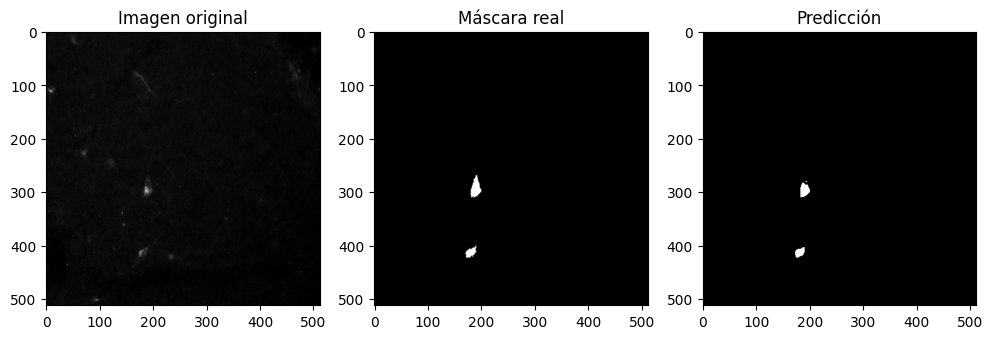

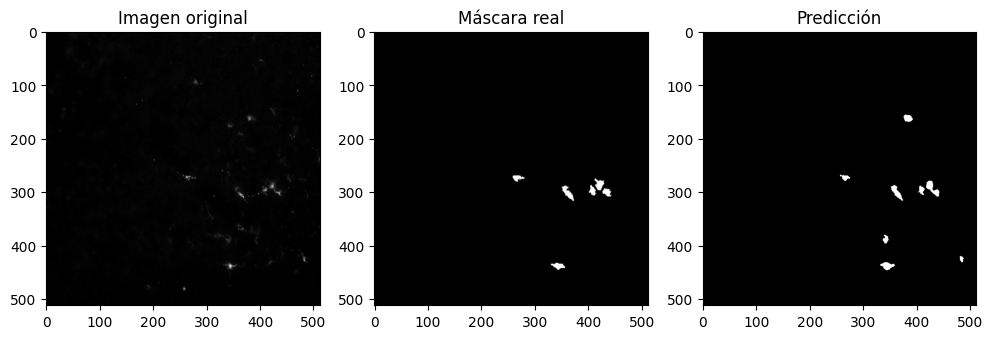

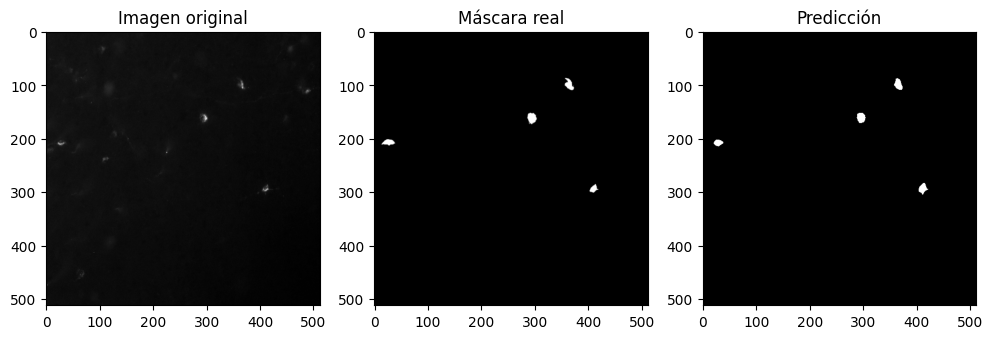

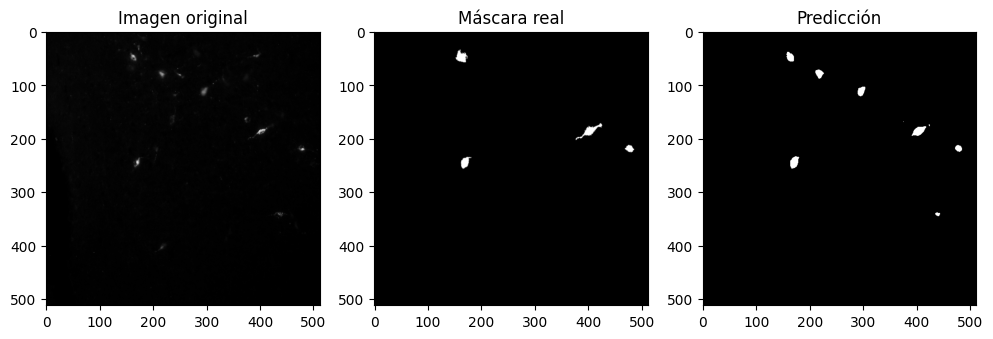

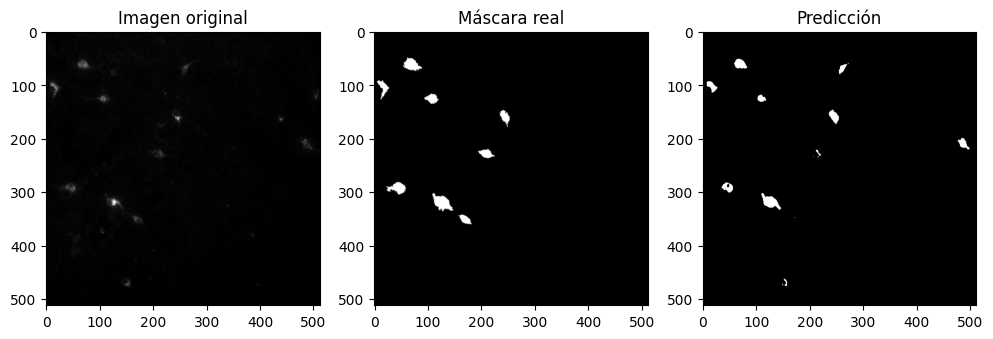

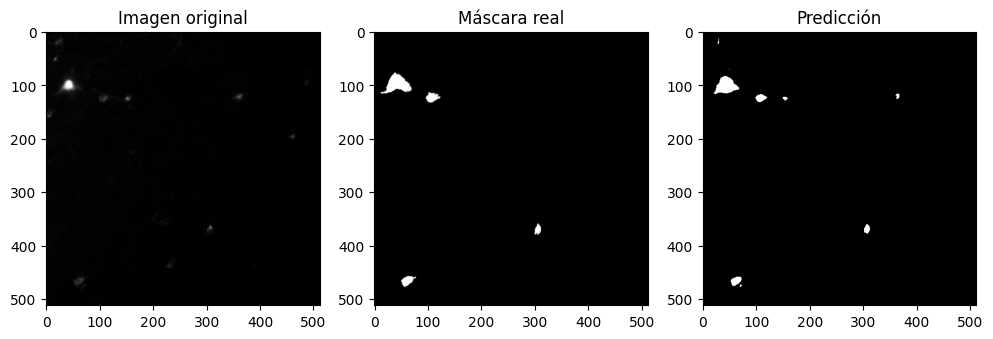

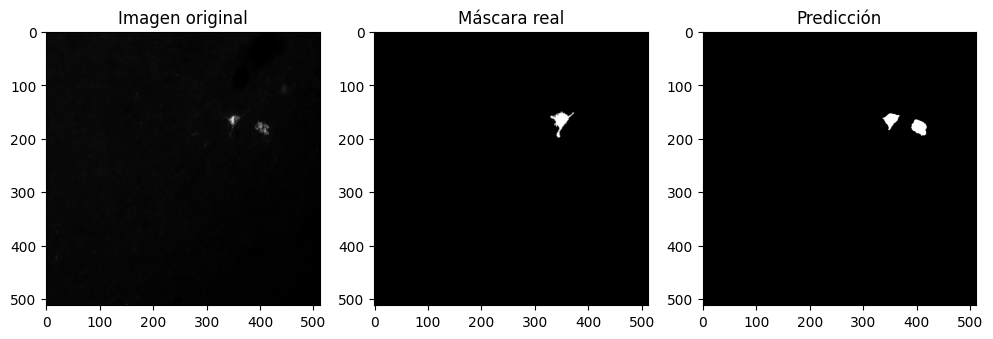

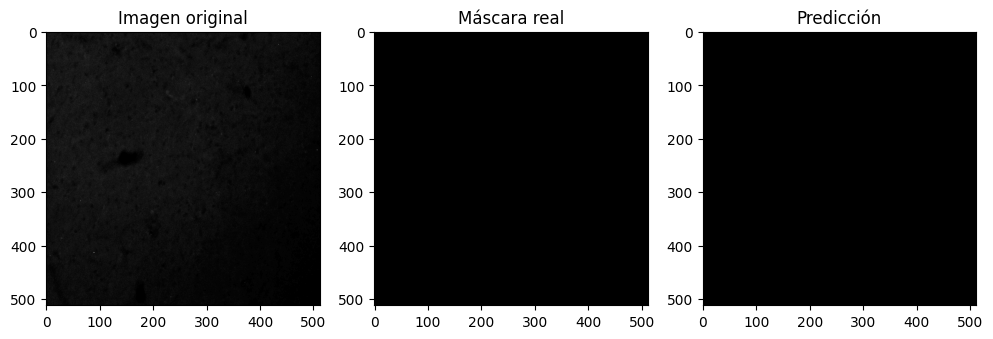

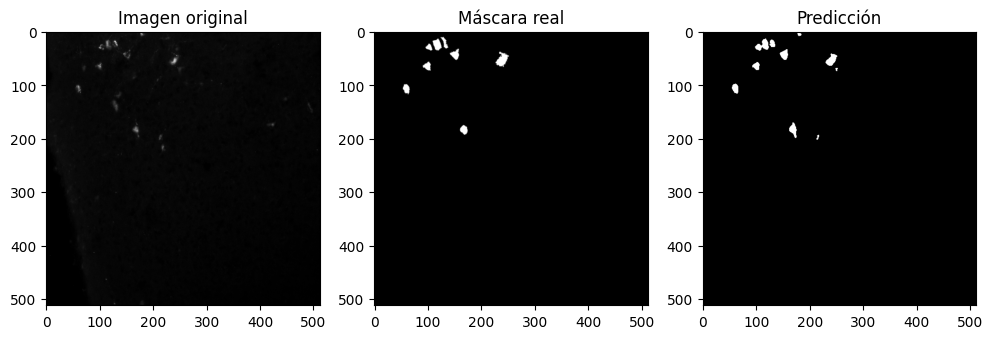

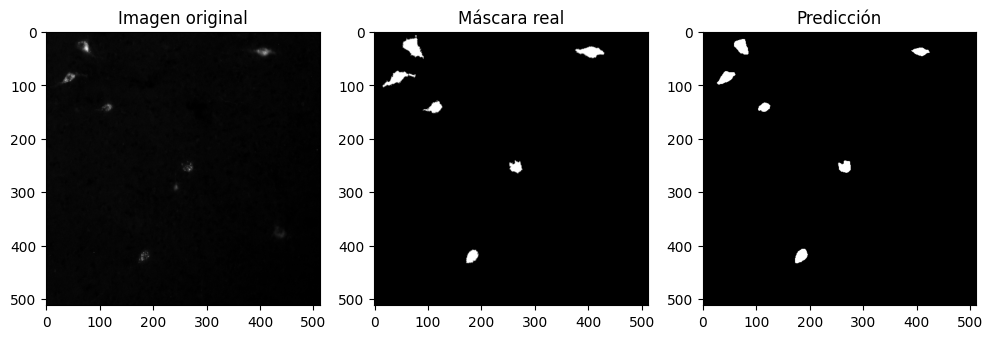

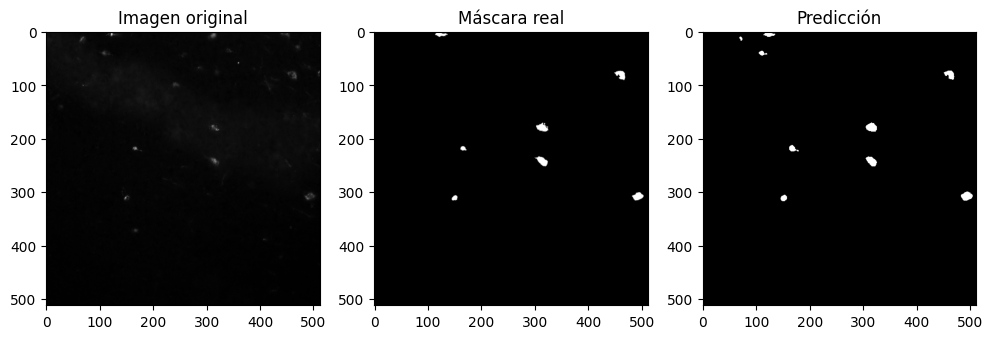

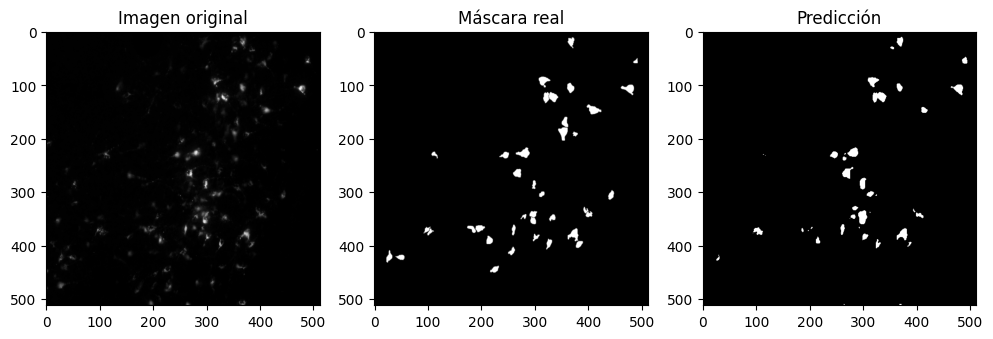

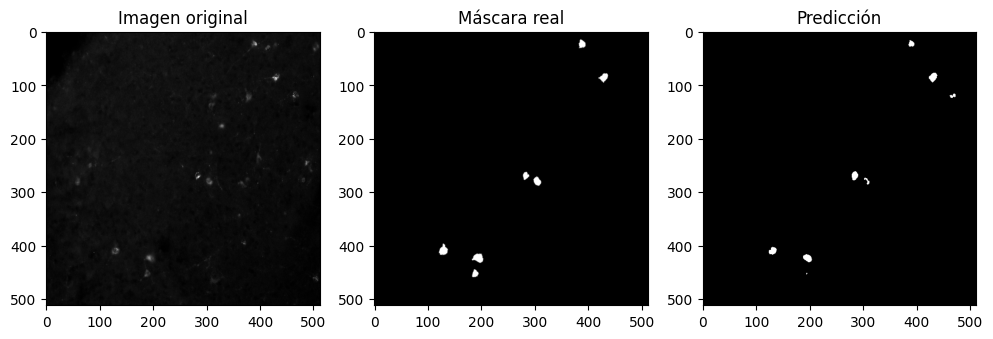

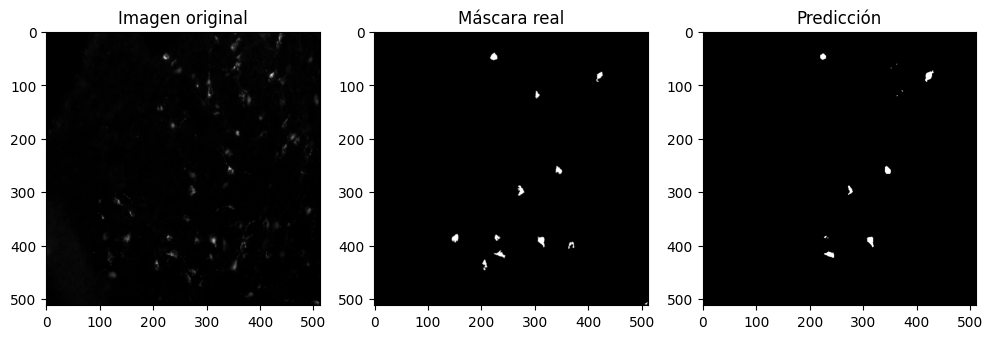

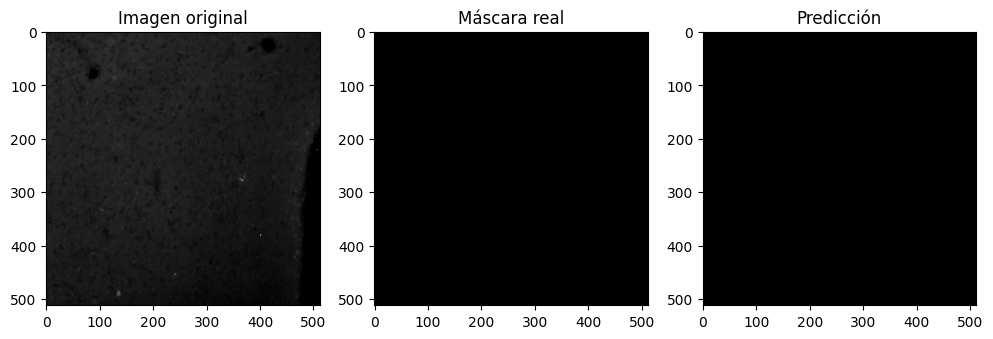

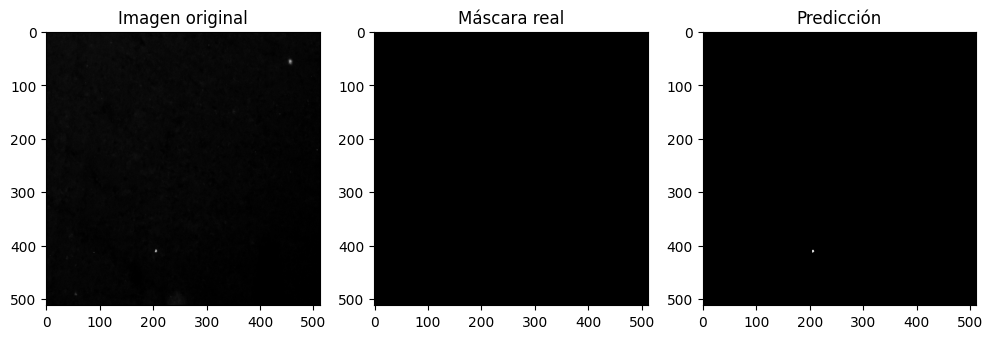

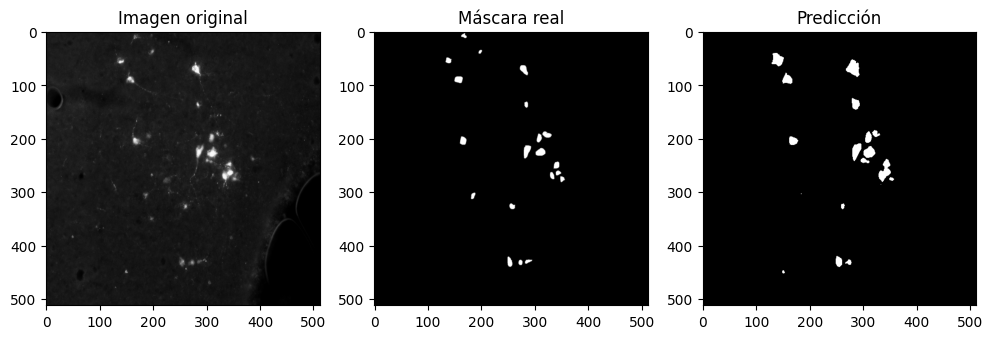

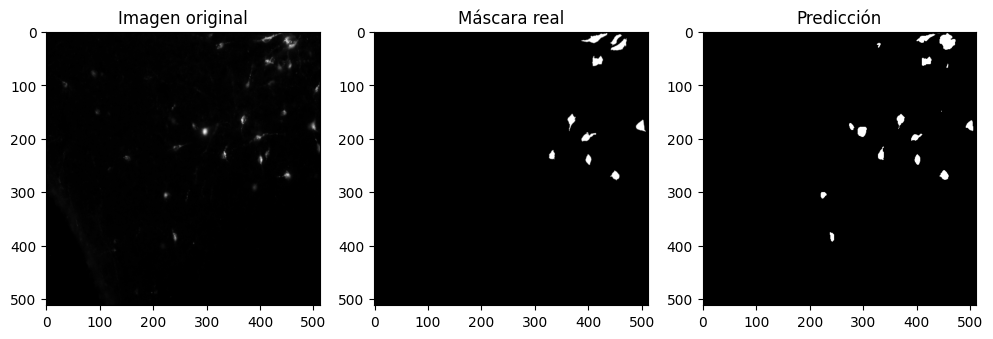

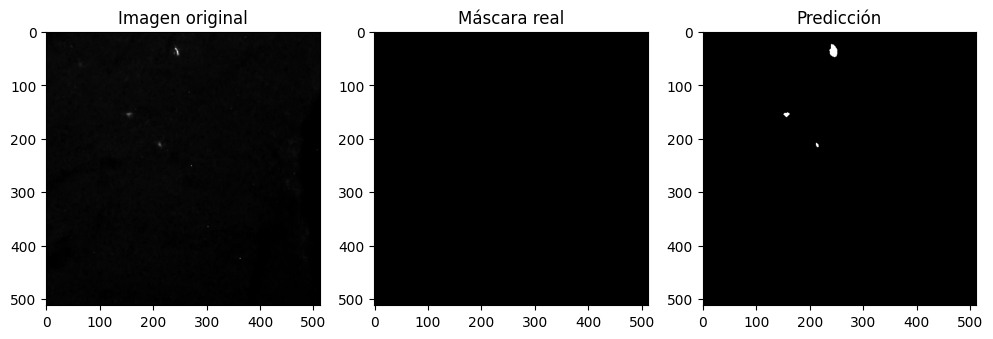

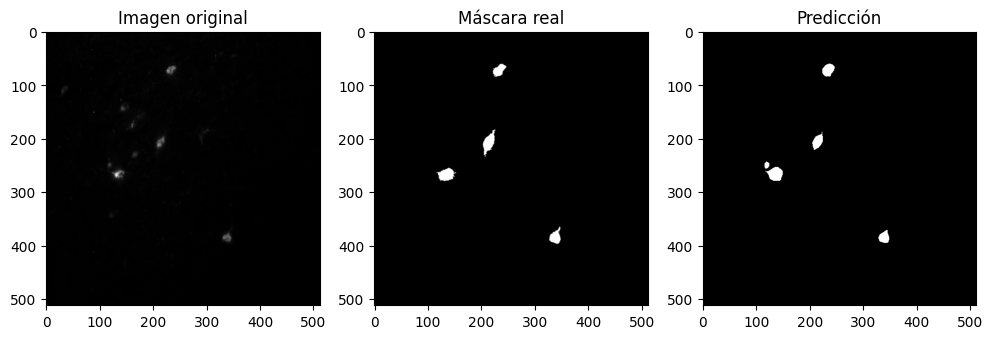

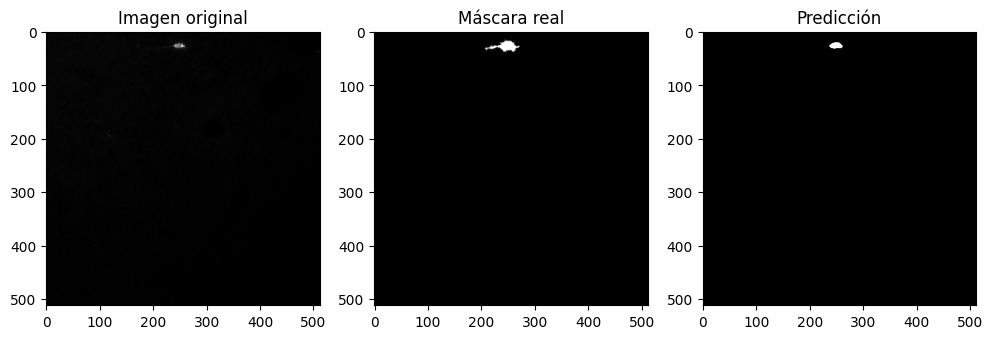

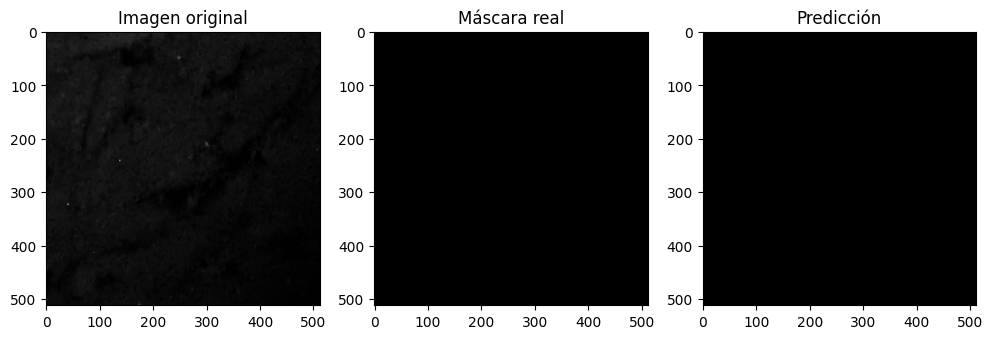

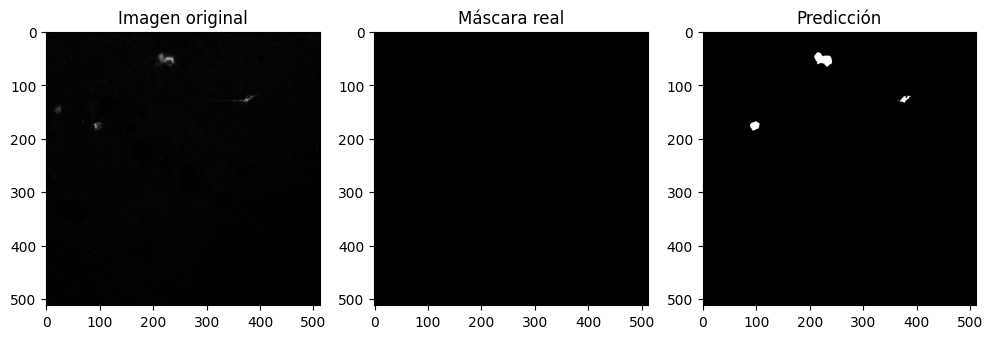

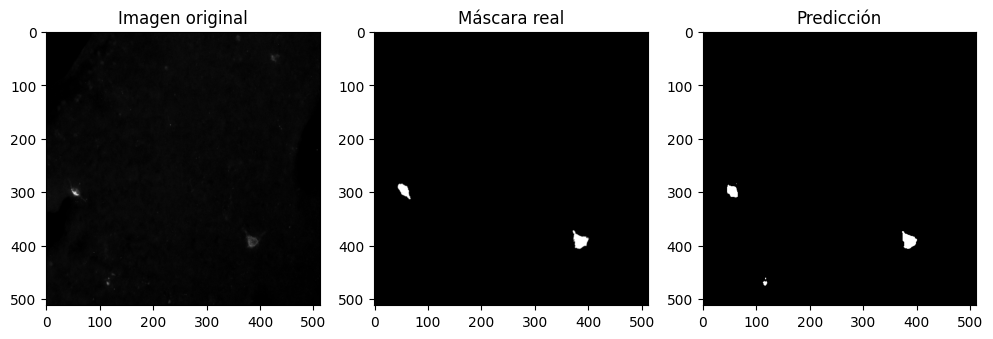

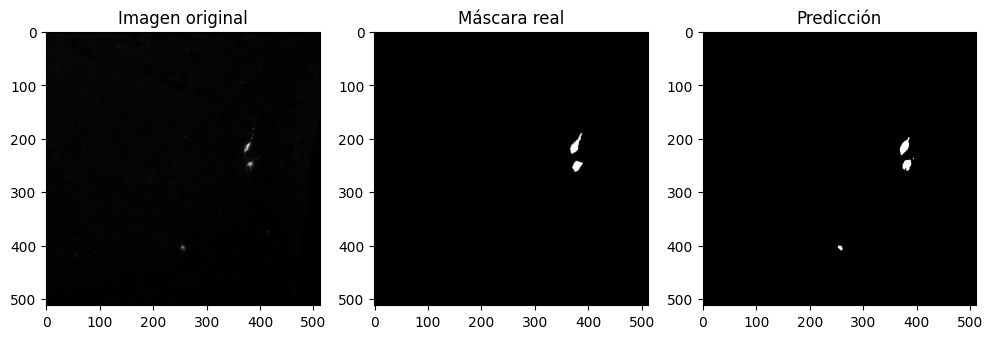

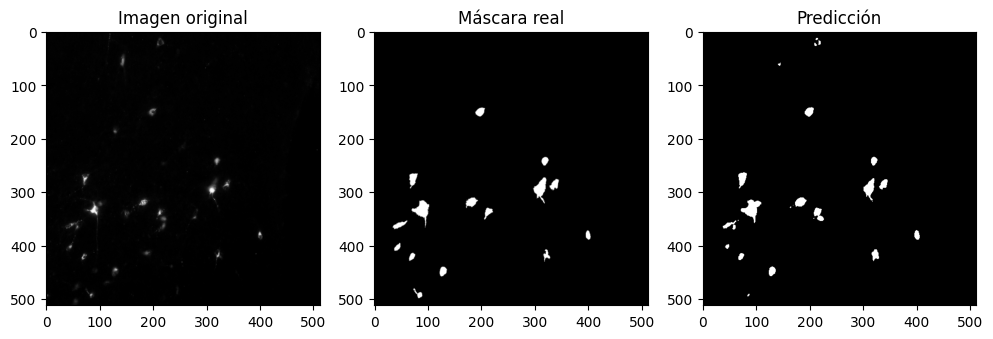

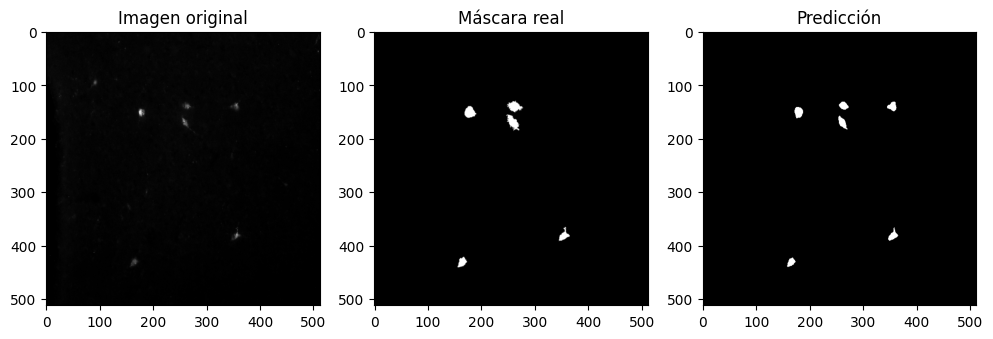

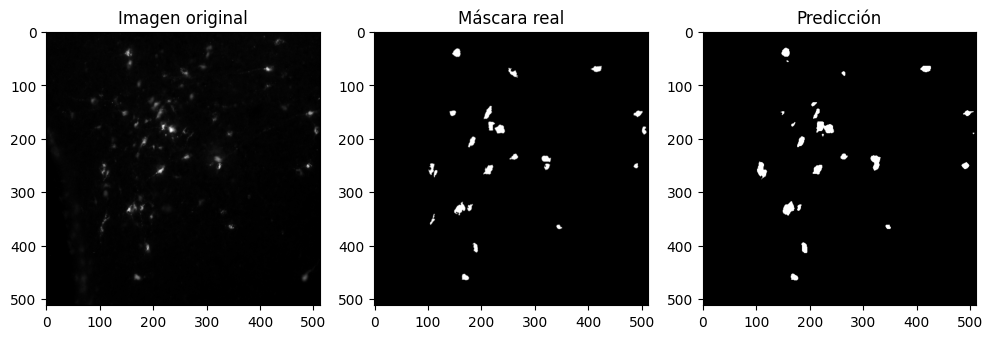

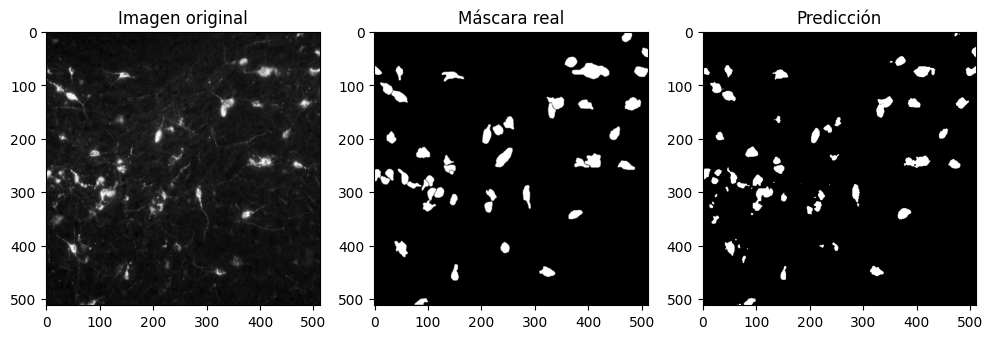

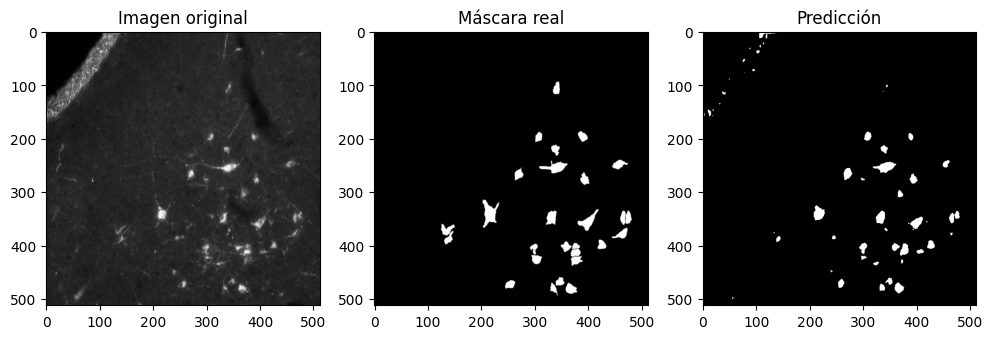

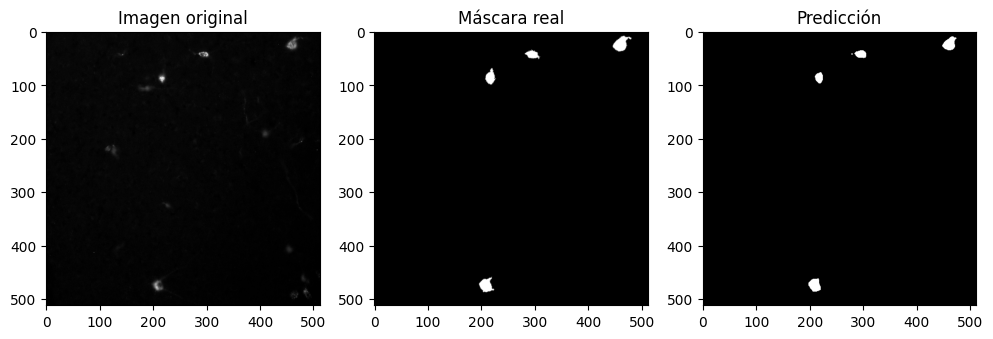

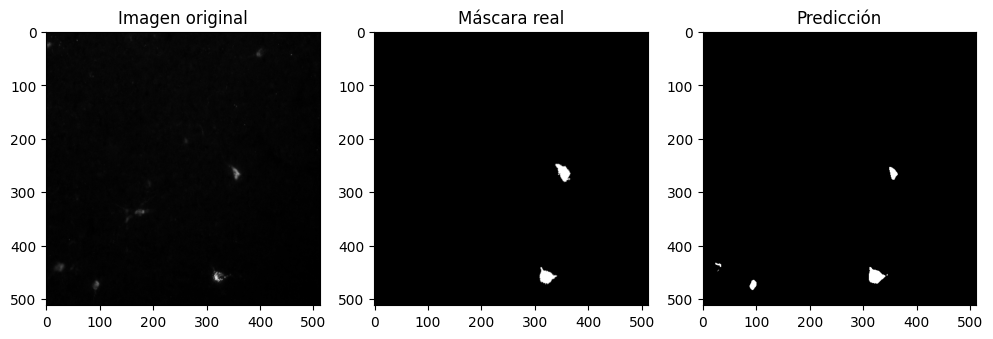

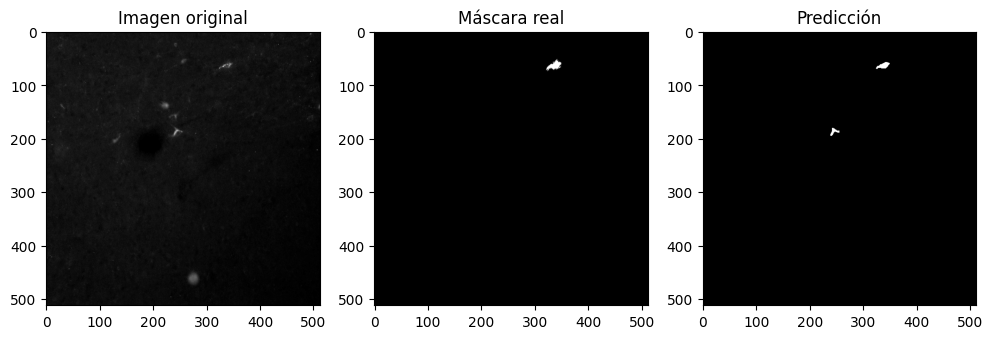

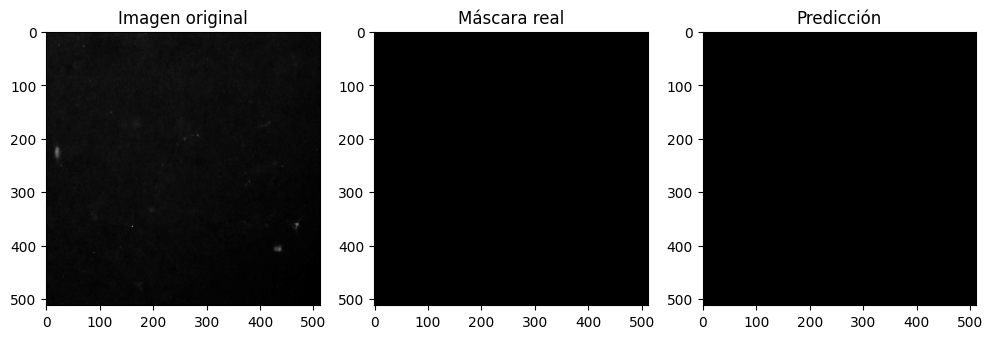

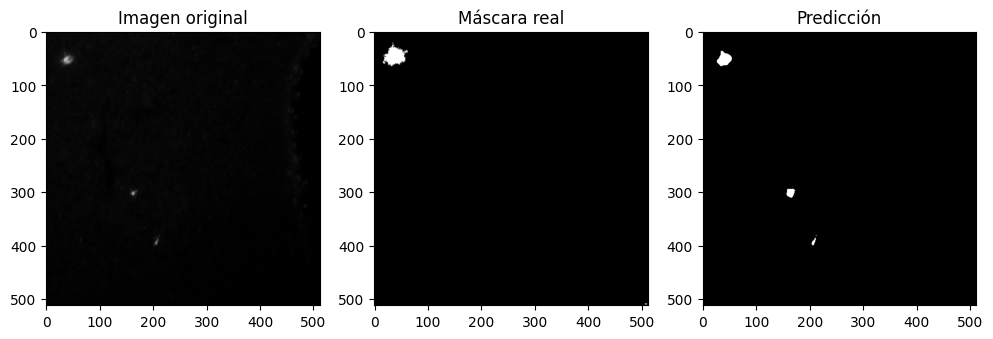

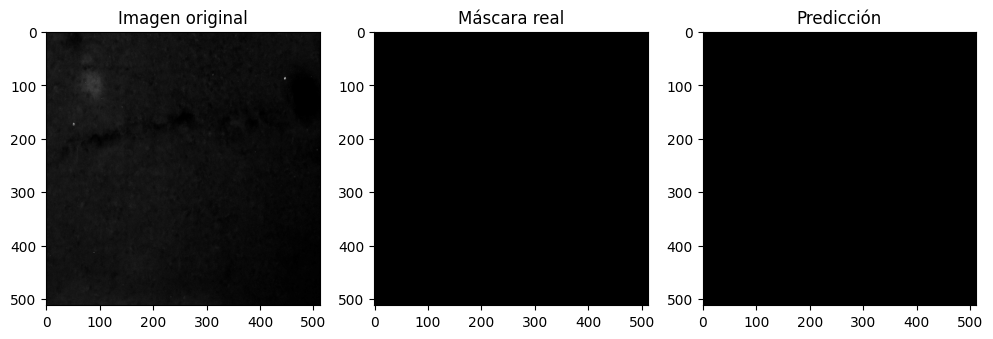

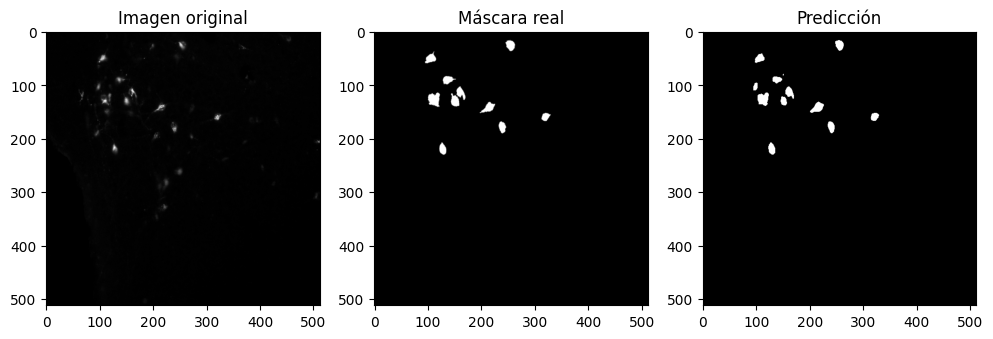

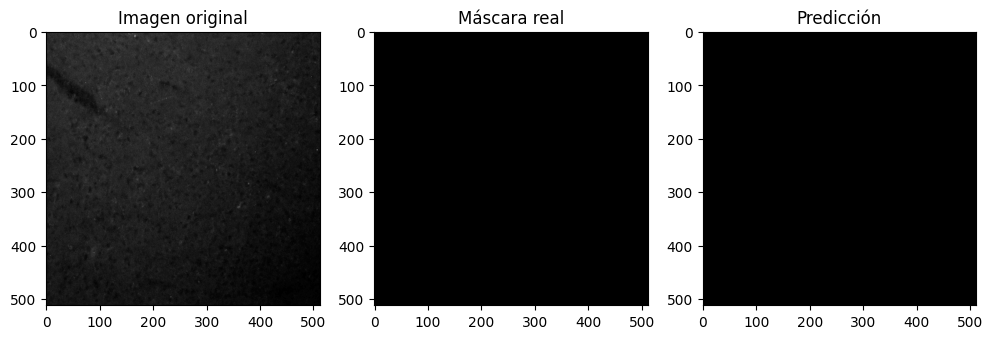

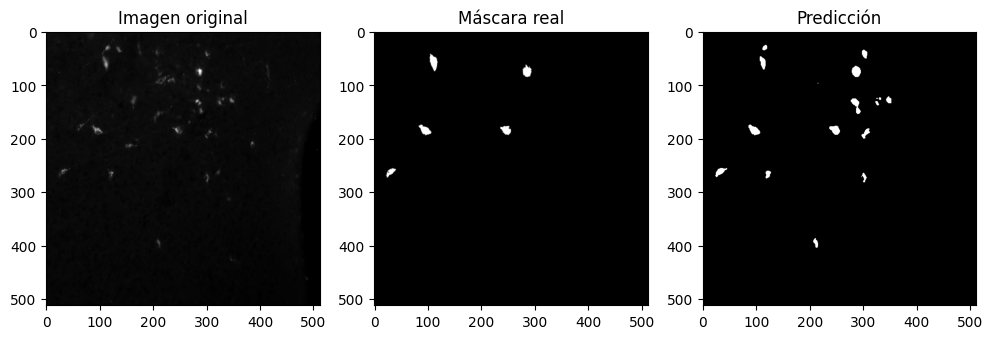

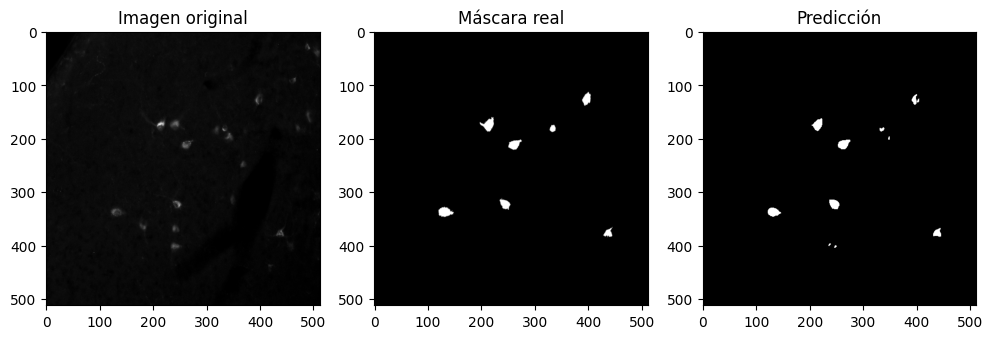

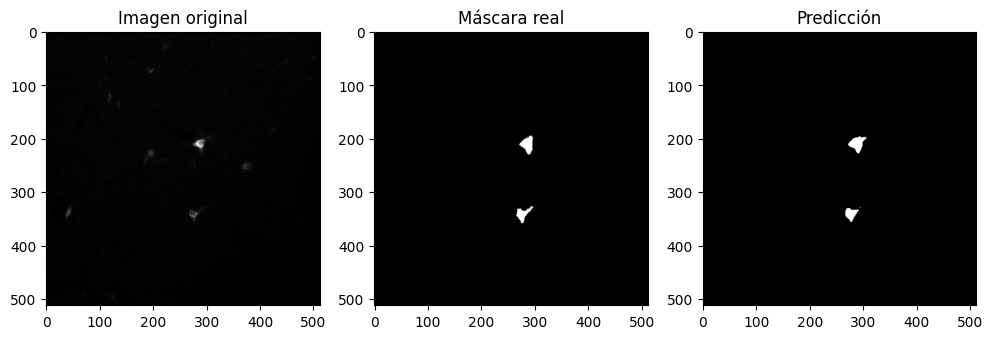

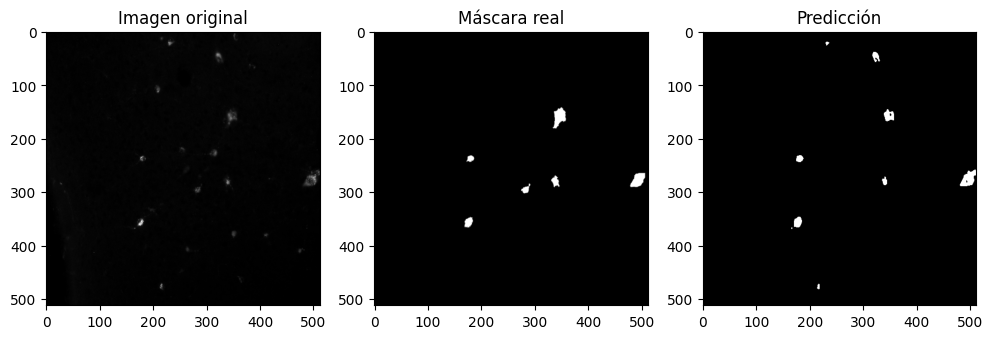

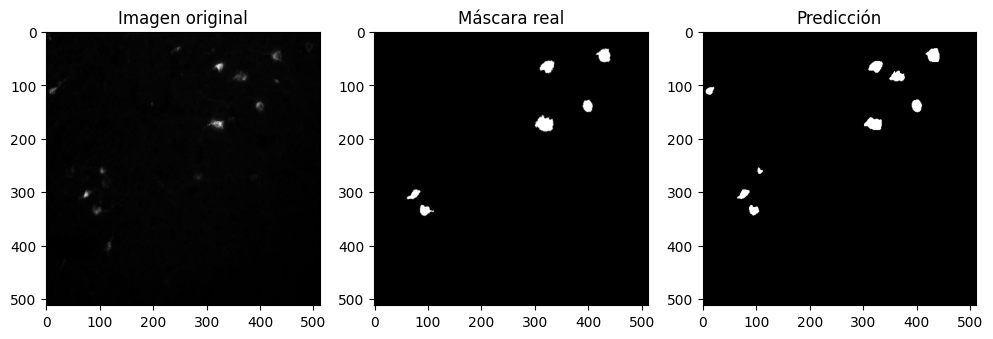

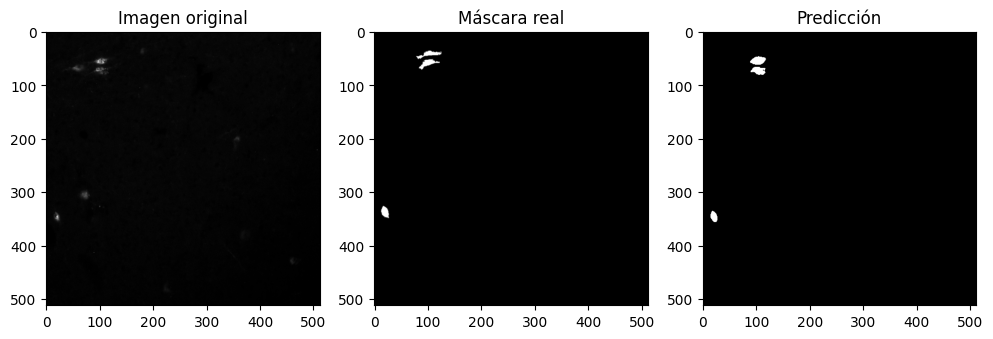

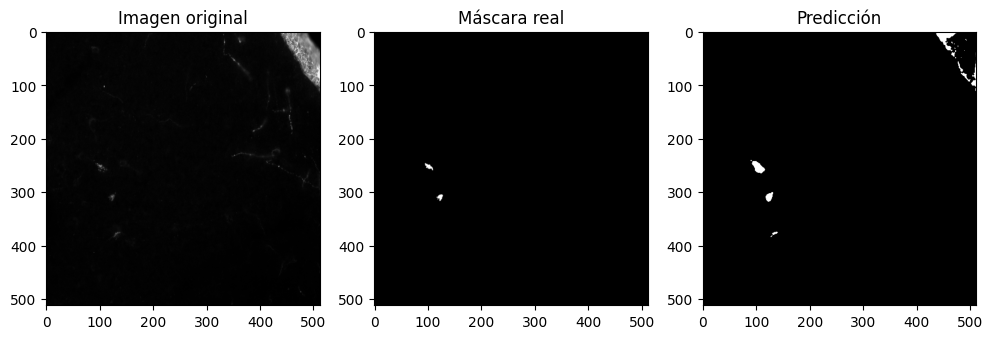

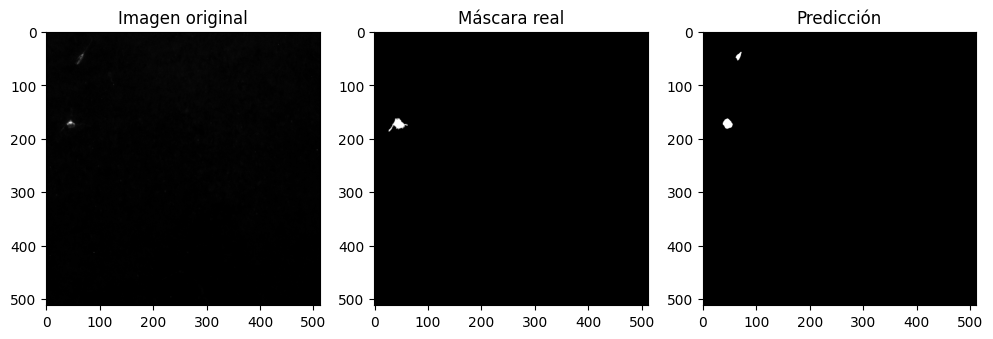

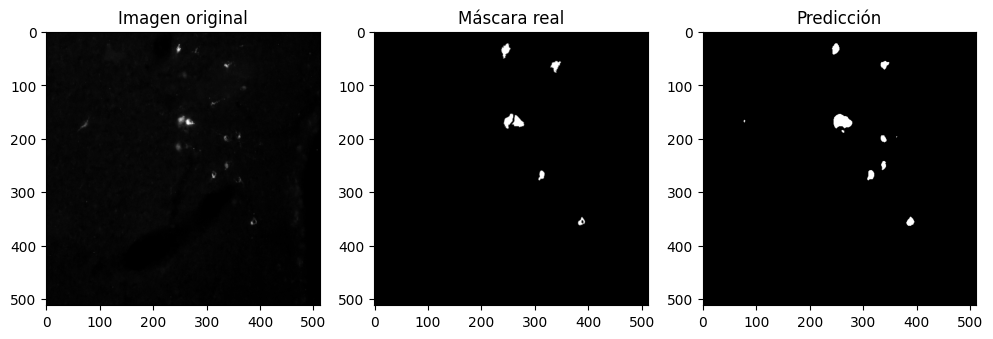

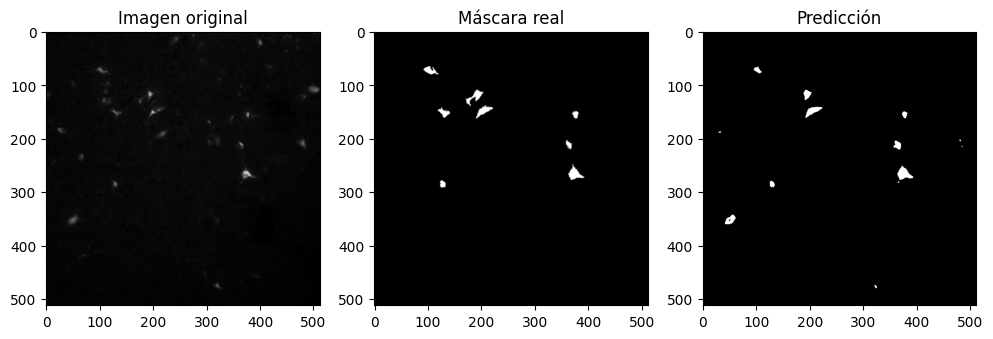

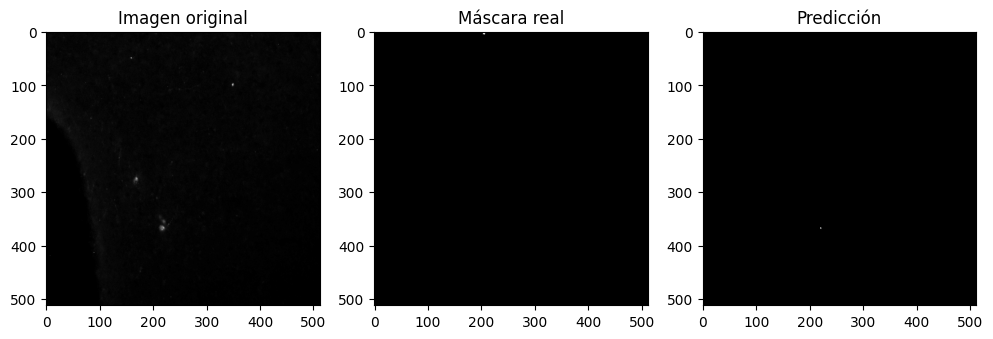

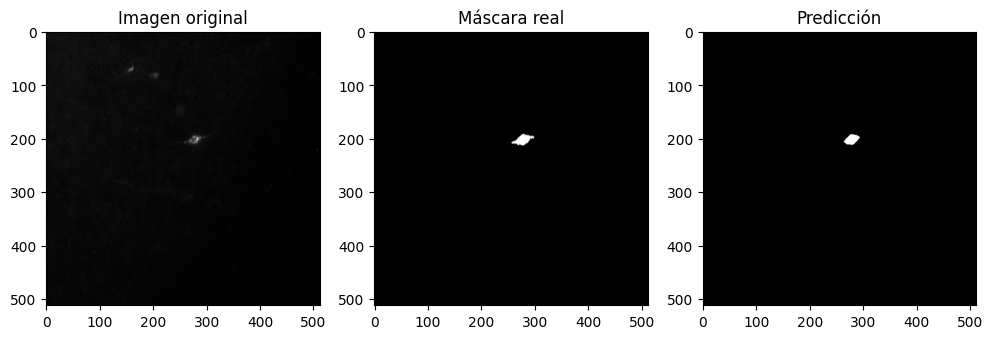

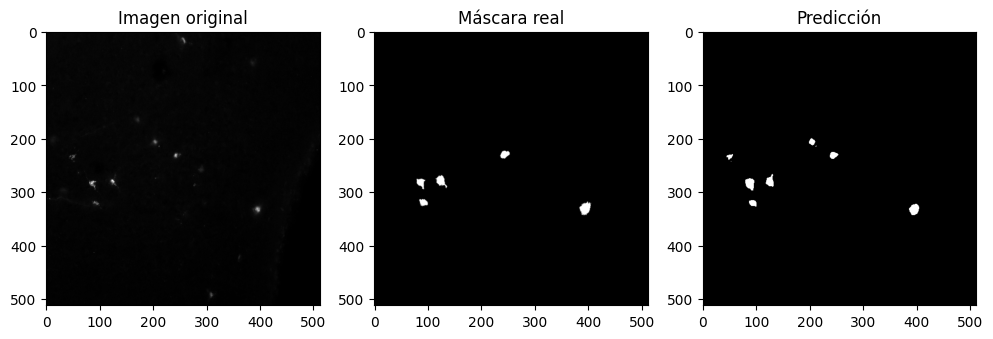

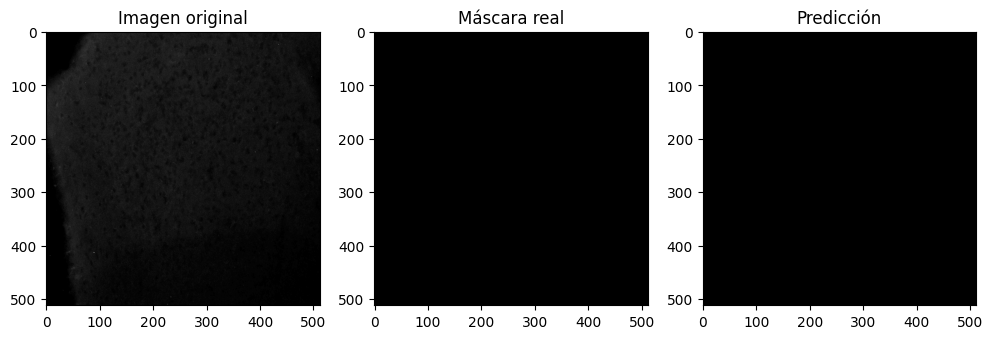

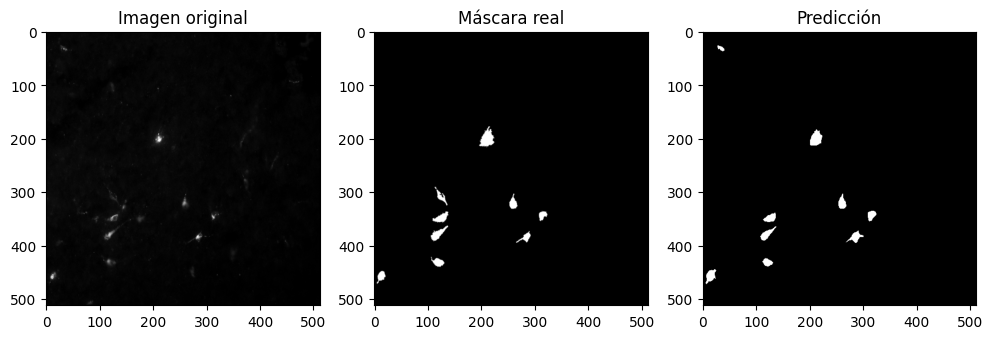

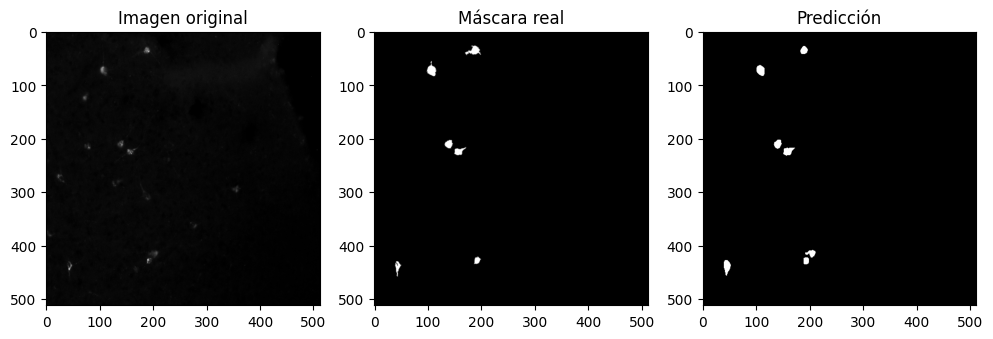

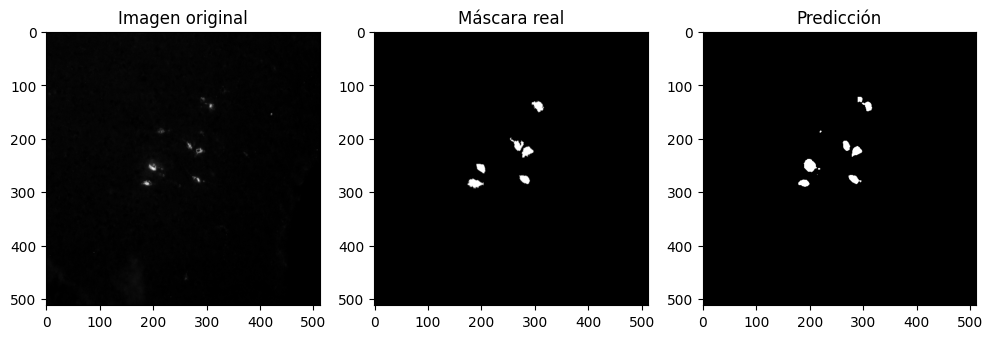

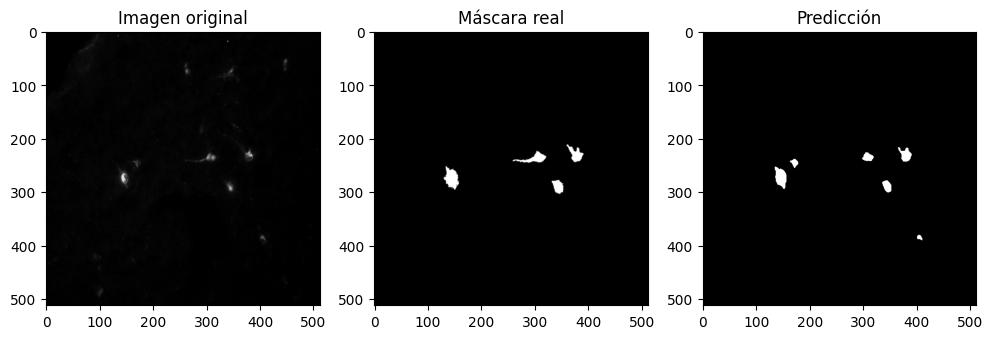

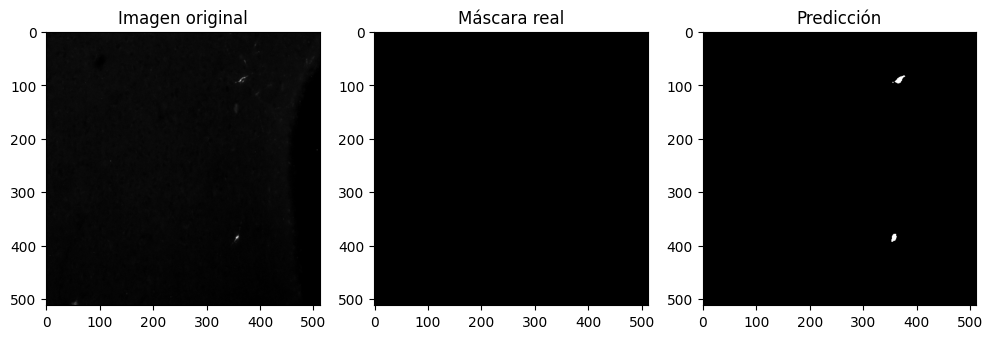

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Mostrar imágenes originales, máscaras reales y predicciones
            for j in range(len(images)):
                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(images[j].cpu().squeeze(), cmap='gray')
                axes[0].set_title('Imagen original')
                axes[1].imshow(masks[j].cpu().squeeze(), cmap='gray')
                axes[1].set_title('Máscara real')
                axes[2].imshow(predictions[j].cpu().squeeze(), cmap='gray')
                axes[2].set_title('Predicción')

                plt.show()

# Visualizar algunas predicciones
visualize_predictions(model, val_loader)
